phase list size:  7000  amp list size:  7000


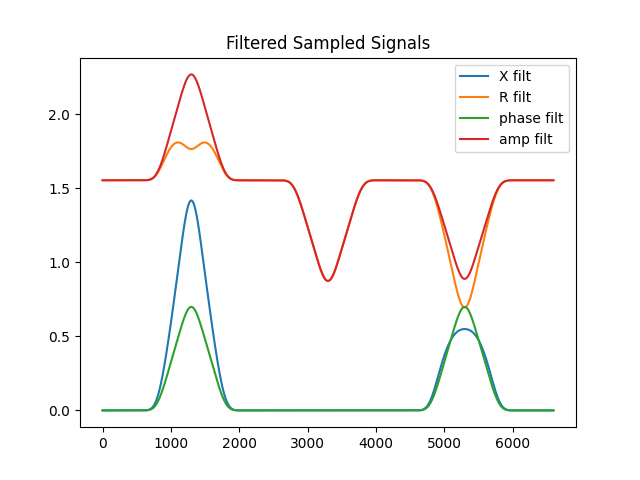

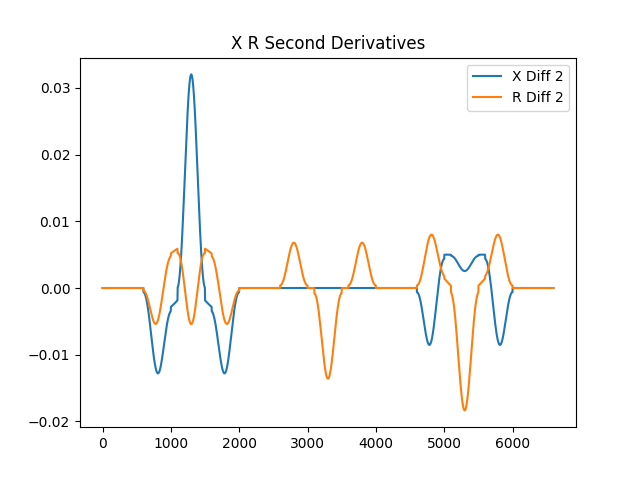

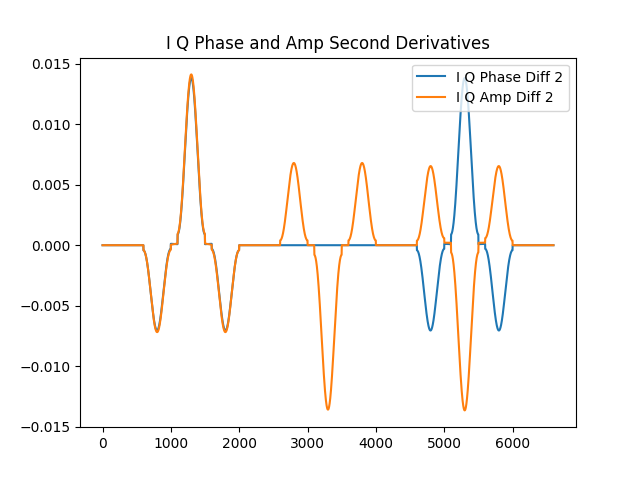

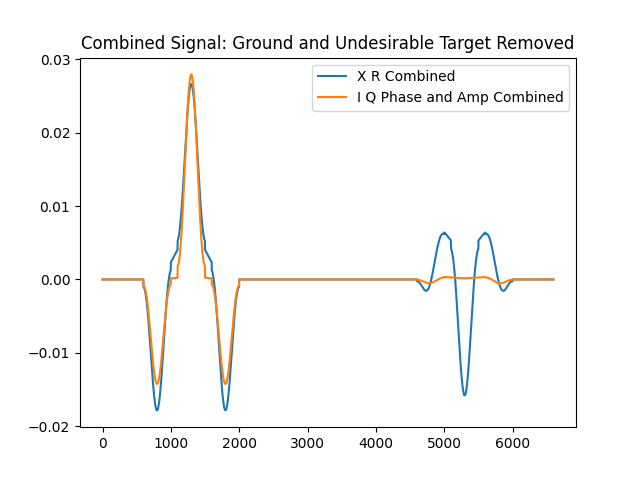

In [29]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import math as m
import scipy.signal as signal

def GetInvertedAmplifiedSecondDerivative(array, gain1, gain2):
    diff1 = np.diff(array) * gain1
    diff2 = -1 * np.diff(diff1) * gain2
    return diff2

def GetTwoFilteredSignals(signal1, signal2, windowSize, cutoffFreqLow, cutoffFreqHigh, sampleRate):
    # window types: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window
    firFilter = signal.firwin(windowSize, cutoff = [cutoffFreqLow, cutoffFreqHigh], window = "hamming", pass_zero = "bandpass", fs=sampleRate)
    filt1 = signal.lfilter(firFilter, 1, signal1)[windowSize:]
    filt2 = signal.lfilter(firFilter, 1, signal2)[windowSize:]
    return (filt1, filt2)
    

# Free up memory from previous runs
plt.close()

# Wave and sampling parameters
sampleRate = 500000.0
frequency = 10000.0
amplitude = 1.5
numCycles = 1

# Wave and sampling calculations
period = 1.0/frequency #seconds per cycle
samplesPerCycle = sampleRate/frequency


# Set up the simulated phase pulses
phaseMax = 45.0
phasePulseList = np.concatenate((
    np.zeros(1000), 
    np.linspace(0, 1, 500) * phaseMax, 
    np.linspace(1, 0, 500) * phaseMax,
    np.zeros(1000),
    np.zeros(500),
    np.zeros(500),
    np.zeros(1000),
    np.linspace(0, 1, 500) * phaseMax, 
    np.linspace(1, 0, 500) * phaseMax,
    np.zeros(1000), 
))

# Set up the simulated amplitude pulses
ampMax = 0.75
ampPulseList = np.concatenate((
    np.zeros(1000), 
    np.linspace(0, 1, 500) * ampMax, 
    np.linspace(1, 0, 500) * ampMax,
    np.zeros(1000),
    np.linspace(0, -1, 500) * ampMax, 
    np.linspace(-1, 0, 500) * ampMax,
    np.zeros(1000),
    np.linspace(0, -1, 500) * ampMax, 
    np.linspace(-1, 0, 500) * ampMax,
    np.zeros(1000), 
))
print("phase list size: ", phasePulseList.size, " amp list size: ", ampPulseList.size)
if phasePulseList.size != ampPulseList.size:
    print("Error: phase and amp list sizes don't match")
    exit()

# Calculate sine waves at varying phase offsets and amplitudes to simulate target pulses
signalX = []
signalR = []
signalPhaseCalc = []
signalAmpCalc = []
for i in range(0, phasePulseList.size):
    phase = phasePulseList[i]
    finalAmplitude = amplitude + ampPulseList[i];
    signalAtReceiveCoil = finalAmplitude * np.sin(np.linspace(0, period * numCycles, int(samplesPerCycle*numCycles)) * 2*np.pi*frequency + np.deg2rad(phase))
    
    sampleX = signalAtReceiveCoil[0]
    signalX.append(sampleX)
    sampleR = signalAtReceiveCoil[int(samplesPerCycle/4)]
    signalR.append(sampleR)

    phaseCalc = m.atan2(sampleX, sampleR)
    signalPhaseCalc.append(phaseCalc)
    ampCalc = m.sqrt(sampleX*sampleX + sampleR*sampleR)
    signalAmpCalc.append(ampCalc)

# Filter the sampled signals (TODO: work out sample rate?)
signalXSmooth, signalRSmooth = GetTwoFilteredSignals(signalX, signalR, 401, 1, 10, int(sampleRate/samplesPerCycle))
signalPhaseSmooth, signalAmpSmooth = GetTwoFilteredSignals(signalPhaseCalc, signalAmpCalc, 401, 1, 10, int(sampleRate/samplesPerCycle))


# Calculate the second derivative (w/ some gain)
signalXDiff2 = GetInvertedAmplifiedSecondDerivative(signalXSmooth, 30, 30)
signalRDiff2 = GetInvertedAmplifiedSecondDerivative(signalRSmooth, 30, 30)
signalPhaseDiff2 = GetInvertedAmplifiedSecondDerivative(signalPhaseSmooth, 30, 30)
signalAmpDiff2 = GetInvertedAmplifiedSecondDerivative(signalAmpSmooth, 30, 30)

# Calculate a "combined" signal that represents what would make the metal detector beep
# The first "penny" pulse should remain, the second "ground interference" pulse should be removed, and the third "discriminated-out iron" pulse should be removed

addConditionXR = np.where(signalXDiff2 != 0, True, False)
combinedSignalXR = np.array(signalXDiff2)
np.add(signalXDiff2, signalRDiff2, out=combinedSignalXR, where=addConditionXR)

addCondition = np.where(signalPhaseDiff2 != 0, True, False)
combinedSignal = np.array(signalPhaseDiff2)
np.add(signalPhaseDiff2, signalAmpDiff2, out=combinedSignal, where=addCondition)

fig = plt.figure()
plt.title("Filtered Sampled Signals")
plt.plot(signalXSmooth, label="X filt")
plt.plot(signalRSmooth, label="R filt")
plt.plot(signalPhaseSmooth, label="phase filt")
plt.plot(signalAmpSmooth, label="amp filt")
plt.legend(loc="upper right")

fig = plt.figure()
plt.title("X R Second Derivatives")
plt.plot(signalXDiff2, label="X Diff 2");
plt.plot(signalRDiff2, label="R Diff 2");
plt.legend(loc="upper right")

fig = plt.figure()
plt.title("I Q Phase and Amp Second Derivatives")
plt.plot(signalPhaseDiff2, label="I Q Phase Diff 2");
plt.plot(signalAmpDiff2, label="I Q Amp Diff 2");
plt.legend(loc="upper right")

fig = plt.figure()
plt.title("Combined Signal: Ground and Undesirable Target Removed")
plt.plot(combinedSignalXR, label="X R Combined")
plt.plot(combinedSignal, label="I Q Phase and Amp Combined")
plt.legend(loc="upper right")